**Contents**

- [Introduction](#Introduction)
- [Time-varying input](#Time-varying-input)
    - [Dense time reachability plots](#dense-reach-plots-TV)
    - [Check mode (dense time)](#check-dense-TV)
    - [Check mode (discrete time)](#check-discrete-TV)
    - [Advanced settings: lazy inputs](#Advanced-settings-lazy-inputs)
- [Constant input](#Constant-input)
    - [Dense time reachability plots](#dense-reach-plots-CONST)
    - [Check mode (dense time)](#check-dense-CONST)
    - [Check mode (discrete time)](#check-discrete-CONST)

## Introduction

This system is a continuous linear time-invariant system $x'(t) = Ax(t) + Bu(t)$ proposed as a benchmark in ARCH 2016 as "International Space Station (ISS)". 

The ISS state-space model is a structural model of component 1R (Russian service module) of the International Space Station. It has 270 state variables with three inputs.

In [2]:
using Plots, MAT, SparseArrays
using Revise, ReachabilityAnalysis
const RA = ReachabilityAnalysis
LazySets.set_ztol(Float64, 1e-14)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


1.0e-14

In [ ]:
function add_dimension(A::AbstractMatrix, m=1)
    n = size(A, 1)
    return vcat(hcat(A, zeros(n, m)), zeros(m, n+m))
end

## ISSF01: Time-varying input <a id='Time-varying-input'> </a>

We build the scenario as an initial value problem with non-deterministic inputs. We assume that the inputs can change arbitrarily over time: $\forall t, u(t) \in \mathcal{U}$. This is the `ISSF01` scenario.

In [ ]:
using JLD2

In [2]:
file = matopen("iss.mat")

MAT.MAT_v5.Matlabv5File(IOStream(<file iss.mat>), false, #undef)

In [3]:
A, B = sparse(read(file, "A")), read(file, "B")
C3 = read(file, "C")[3, :] # y3 is the third row
@show typeof(C3)
@show length(C3)

X0 = BallInf(zeros(size(A, 1)), 0.0001)  # -0.0001 <= xi <= 0.0001 for all i
U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.]);  # input set

prob_ISSF01 = @ivp(x' = A*x + B*u, x(0) ∈ X0, u ∈ U, x ∈ Universe(270));

typeof(C3) = SparseVector{Float64,Int64}
length(C3) = 270


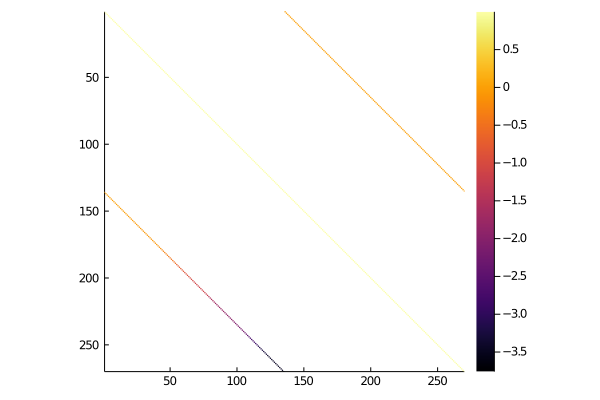

In [24]:
spy(exp(Matrix(A) * 1e-3))

### ISSF01 with LGG09

In [4]:
using BenchmarkTools

In [7]:
sol = nothing
GC.gc()

In [8]:
algo = LGG09(δ=6e-4, template=C3, sparse=true, cache=false)
@time sol = solve(prob_ISSF01, T=20.0, alg=algo);

times = [@elapsed solve(prob_ISSF01, T=20.0, alg=algo) for _ in 1:8];
@show sum(times) / length(times)
@show ρ(C3, sol)

  4.004169 seconds (675.59 k allocations: 437.529 MiB, 0.98% gc time)
sum(times) / length(times) = 3.904553147375
ρ(C3, sol) = 0.0006906243653573876


0.0006906243653573876

Result with `sparse` $\Phi$ and no cache:

```julia
  4.087650 seconds (608.92 k allocations: 434.986 MiB, 0.86% gc time)
```

```julia
    5.656007 seconds (774.75 k allocations: 230.280 MiB, 0.28% gc time)
```

---

In [9]:
sol = nothing
GC.gc()

In [10]:
dirs = CustomDirections([C3, -C3])
algo = LGG09(δ=6e-4, template=dirs, sparse=true, cache=false)
@time sol = solve(prob_ISSF01, T=20.0, alg=algo);

times = [@elapsed solve(prob_ISSF01, T=20.0, alg=algo) for _ in 1:8];
@show sum(times) / length(times)

  7.794941 seconds (1.34 M allocations: 755.175 MiB, 0.92% gc time)
sum(times) / length(times) = 8.24202857175
ρ(C3, sol) = 0.0006906243653573876


0.0006906243653573876

In [11]:
@show ρ(C3, sol)
@show -ρ(-C3, sol)

ρ(C3, sol) = 0.0006906243653573876
-(ρ(-C3, sol)) = -0.0006864686594464852


-0.0006864686594464852

### ISSF01 with BOX

In [12]:
@time solbox = solve(problem_TV, T=1.0, alg=BOX(δ=1e-3));
#   0.572036 seconds (8.24 k allocations: 259.338 MiB, 38.94% gc time)

  0.552744 seconds (5.66 k allocations: 259.298 MiB, 22.21% gc time)


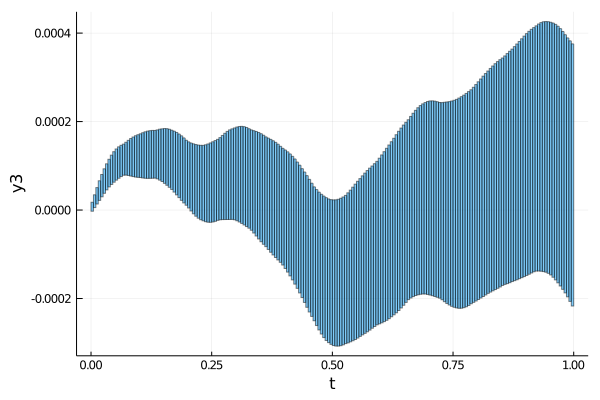

In [13]:
y₃box = project(solbox, M)
plot(y₃box, vars=(0, 1), xlabel="t", ylabel="y3")

In [68]:
@time solbox = solve(problem_TV, T=20.0, alg=BOX(δ=5e-3));

  4.514119 seconds (46.25 k allocations: 2.367 GiB, 0.62% gc time)


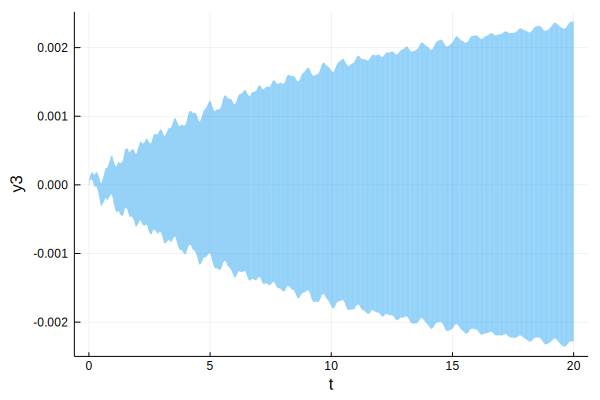

In [70]:
y₃box = Flowpipe([linear_map(M, X) for X in solbox]);
plot(y₃box, vars=(0, 1), xlabel="t", ylabel="y3", lw=0.0)

### ISSF01 with GLGM06

In [ ]:
@time solzono = solve(problem_TV, T=1.0, alg=GLGM06(δ=1e-3, max_order=10));

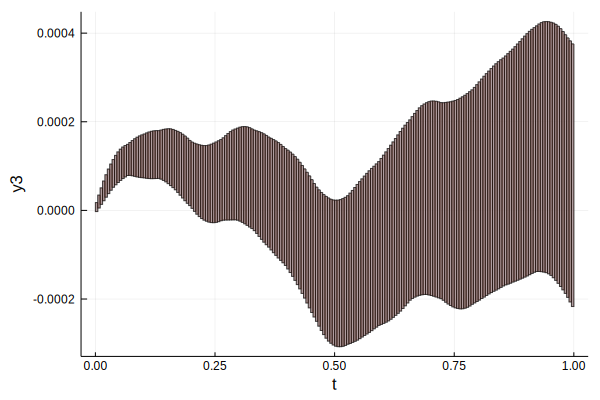

In [30]:
y₃zono = Flowpipe([linear_map(M, X) for X in solzono]);
plot!(y₃zono, vars=(0, 1), xlabel="t", ylabel="y3")

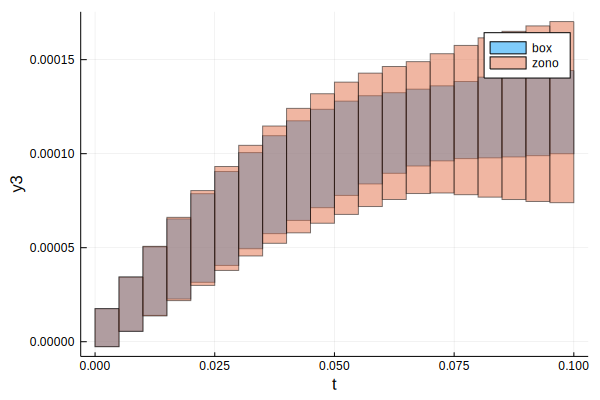

In [25]:
plot(y₃box[1:20], vars=(0, 1), xlabel="t", ylabel="y3", lab="box")
plot!(y₃zono[1:20], vars=(0, 1), xlabel="t", ylabel="y3", lab="zono")

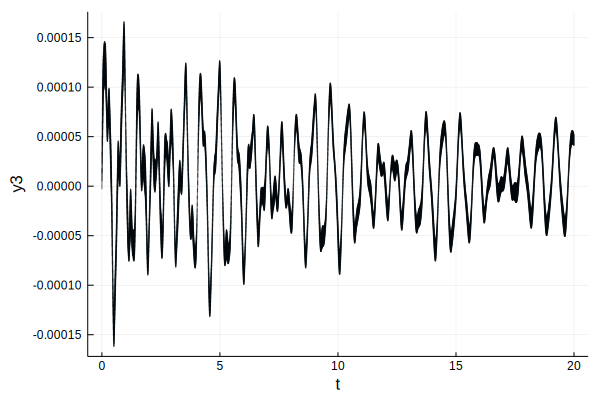

In [51]:
plot(y₃, vars=(0, 1), xlabel="t", ylabel="y3")

### ISSF01 with BFFPSV18

In [ ]:
M = reshape(Cvec, 1, 270)
C = SparseMatrixCSC(nonzeros(C3)')
vars = filter(!iszero, C)  # vars == collect(136:270)
part = [collect(1:135), collect(136:270)]

In [95]:
alg = BFFPSV18(δ=6e-4, sparse=true, setrep=Hyperrectangle, vars=136:270, partition = [collect(1:135), collect(136:270)])

@time sol = solve(problem_TV, T=1.0, alg=alg);

  0.314779 seconds (2.39 k allocations: 115.719 MiB, 3.02% gc time)
this no view
SparseMatrixCSC{Float64,Int64}
 38.625032 seconds (2.33 M allocations: 2.197 GiB, 0.59% gc time)


In [ ]:
p = vcat([i:i for i in 1:135], [136:270])
p = [collect(1:135), collect(136:270)]
alg = BFFPSV18(δ=1e-3, sparse=true, setrep=Hyperrectangle, vars=[182], partition=p)
@time sol = solve(problem_TV, T=1.0, alg=alg);

  0.864156 seconds (2.39 k allocations: 115.719 MiB, 2.28% gc time)


In [89]:
I270 = Matrix(1.0I, 270, 270)
dirs = vcat([I270[:, i] for i in 136:270],
            [-I270[:, i] for i in 136:270])    
alg = LGG09(δ=1e-3, template=dirs)
@time sol = solve(problem_TV, T=1.0, alg=alg);

  6.227623 seconds (812.96 k allocations: 770.005 MiB, 8.60% gc time)


In [32]:
GC.gc()

In [ ]:
sol = solve(problem_TV, :T=>1.0, :δ=>5e-3, :vars=>136:270, :plot_vars=>[0, 270],
                        :projection_matrix=>C, :assume_sparse=>true)

plot(sol, xlabel="t", ylabel="y3")

Time horizon $[0, 20]$:

In [ ]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>5e-3, :vars=>136:270, :plot_vars=>[0, 270],
                        :projection_matrix=>C, :assume_sparse=>true)

plot(sol, xlabel="t", ylabel="y3", indices=1:10:4000)

#### Check mode (dense time) <a id='check-dense-TV'> </a>

For the time-varying case:

- `ISU01`: the specification $y_3 \in [-0.0005, 0.0005]$ should be violated around time ~13.7.
- `ISS01`: the specification $y_3 \in [-0.0007, 0.0007]$ is safe.

In [ ]:
ISU01 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0005)), 
                                  Clause(LinearConstraint(-Cvec, 0.0005))])

ISS01 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0007)), 
                                  Clause(LinearConstraint(-Cvec, 0.0007))]);

In [ ]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>ISU01,
                        :projection_matrix=>C, :assume_sparse=>true, :verbosity=>1);
sol.satisfied, sol.violation

Here `ISU01` is violated, as expected.

In [ ]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>ISS01,
                        :projection_matrix=>C, :assume_sparse=>true, :verbosity=>1);
sol.satisfied, sol.violation

Here `ISS01` is violated. Below we use a refinement to verify this property.

#### Check mode (discrete time)  <a id='check-discrete-TV'> </a>

In [ ]:
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                        :mode=>"check", :property=>ISU01, :projection_matrix=>C, :assume_sparse=>true, :verbosity=>1);
sol.satisfied, sol.violation

In [ ]:
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                        :mode=>"check", :property=>ISS01, :projection_matrix=>C, :assume_sparse=>true, :verbosity=>1);
sol.satisfied, sol.violation

The same observations from dense time apply in discrete time.

#### Advaced settings: lazy inputs  <a id='Advanced-settings-lazy-inputs'> </a>

The `:lazy_inputs_interval` option can be used to modify the length of the interval in which the inputs are handled as a lazy set. Depending on several factors such as partition size, at a higher cost the reach set can be more accurate.

The option `:ε` can be used to define a tolerance for the iterative refinement for polygonal overapproximations of the reachset.

The option `:partition` can be used to define custom block sizes for different sets of variables.

Check if the lazy inputs method shows that `ISS01` is satisfied:

In [ ]:
# continuous time
sol = solve(problem_TV, :approx_model=>"forward", :T=>time_horizon, :δ=>6e-4, :vars=>136:270,
                        :mode=>"check", :property=>ISS01, :projection_matrix=>C, :assume_sparse=>true,
                        :lazy_inputs_interval=>-1, :partition=>[1:135, 136:270], :verbosity=>"info")
sol.satisfied, sol.violation

In [ ]:
                        # discrete time
                        sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=>136:270,
                                                :mode=>"check", :property=>ISS01, :projection_matrix=>C, :assume_sparse=>true,
                                                :lazy_inputs_interval=>-1,
                                                :partition=>[1:135, 136:270], :verbosity=>1);
sol.satisfied, sol.violation

Check if the lazy inputs method shows the violation of `ISU01`:

In [ ]:
# continuous time
sol = solve(problem_TV, :approx_model=>"forward", :T=>time_horizon, :δ=>6e-4, :vars=>136:270,
                        :mode=>"check", :property=>ISU01, :projection_matrix=>C, :assume_sparse=>true,
                        :lazy_inputs_interval=>-1,
                        :partition=>[1:135, 136:270], :verbosity=>1);
sol.satisfied, sol.violation

In [ ]:
# discrete time
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=>136:270,
                        :mode=>"check", :property=>ISU01, :projection_matrix=>C, :assume_sparse=>true,
                        :lazy_inputs_interval=>-1,
                        :partition=>[1:135, 136:270], :verbosity=>1);
sol.satisfied, sol.violation

Make the plot obtained using the `reach` mode and lazy inputs (dense time):

In [ ]:
sol = solve(problem_TV, :T=>time_horizon, :approx_model=>"forward", :δ=>6e-4, :vars=>136:270, :plot_vars=>[0, 270],
                        :projection_matrix=>C, :assume_sparse=>true,
                        :apply_projection=>false, :partition=>part, :lazy_inputs_interval=>-1);

In [ ]:
using LaTeXStrings
gr()

font = Plots.font("Helvetica", 16)

pl = plot(sol, xlabel=L"\textrm{Time}", ylabel=L"$y_3$", indices=1:10:sol.options[:N], size=(380, 380), yformatter=:scientific,
xticks = ([0,5,10, 15, 20],[L"0", L"5", L"10", L"15", L"20"]),
yticks = ([-5.0e-4,-2.5e-4,0, 2.5e-4, 5.0e-4], [L"-5.0", L"-2.5", L"0", L"2.5", L"5.0"]), xtickfont=font,
ytickfont=font, grid=true, legendfont = font, guidefont=font, annotations=(2.5, 7e-4, L"\times 10^{-4}"))

plot!(x->x, x->0.0005, 0.0, time_horizon, line=2, color="red", linestyle=:dash, legend=nothing)
plot!(x->x, x->-0.0005, 0.0, time_horizon, line=2, color="red", linestyle=:dash, legend=nothing)
savefig(pl, "y3_vs_t.png")

## ISSC01

In [18]:
A, B = sparse(read(file, "A")), read(file, "B")
Aext = add_dimension(A, 3);
Aext[1:270, 271:273] = B
S = LinearContinuousSystem(Aext);

C3 = read(file, "C")[3, :] # y3 is the third row
C3_ext = vcat(C3, fill(0.0, 3))

X0 = BallInf(zeros(size(A, 1)), 0.0001)  # -0.0001 <= xi <= 0.0001 for all i
U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.]);  # input set
X0 = X0 * U

prob_ISSC01 = InitialValueProblem(S, X0);

### ISSC01 - dense time

In [24]:
sol = nothing
GC.gc()

In [32]:
dirs = CustomDirections([C3_ext, -C3_ext])
algo = LGG09(δ=0.01, template=dirs, sparse=true, cache=true)
@time sol = solve(prob_ISSC01, T=20.0, alg=algo);

times = [@elapsed solve(prob_ISSC01, T=20.0, alg=algo) for _ in 1:8];
@show sum(times) / length(times)

  0.863333 seconds (35.89 k allocations: 182.958 MiB, 0.56% gc time)
sum(times) / length(times) = 0.7578076244999999


0.7578076244999999

In [33]:
@show ρ(C3_ext, sol)
@show -ρ(-C3_ext, sol)

ρ(C3_ext, sol) = 0.00015863608928218183
-(ρ(-C3_ext, sol)) = -0.0001748343559091847


-0.0001748343559091847

### ISSC01 - discrete time

In [34]:
sol = nothing
GC.gc()

In [35]:
dirs = CustomDirections([C3_ext, -C3_ext])
algo = LGG09(δ=0.01, template=dirs, sparse=true, cache=true, approx_model=NoBloating())
@time sol = solve(prob_ISSC01, T=20.0, alg=algo);

times = [@elapsed solve(prob_ISSC01, T=20.0, alg=algo) for _ in 1:8];
@show sum(times) / length(times)

  0.642104 seconds (846.88 k allocations: 78.771 MiB, 1.26% gc time)
sum(times) / length(times) = 0.240506800125


0.240506800125

In [36]:
@show ρ(C3_ext, sol)
@show -ρ(-C3_ext, sol)

ρ(C3_ext, sol) = 0.00015541009748226768
-(ρ(-C3_ext, sol)) = -0.00017074299025770037


-0.00017074299025770037

#### Dense time reachability plots: <a id='dense-reach-plots-CONST'> </a>

In [ ]:
sol = solve(problem_CONST, :T=>1.0, :δ=>5e-3, :vars=>136:270, :plot_vars=>[0, 270],
                           :projection_matrix=>C, :assume_sparse=>true)

plot(sol, xlabel="t", ylabel="y3")

In [ ]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :plot_vars=>[0, 270],
                           :projection_matrix=>C, :assume_sparse=>true)

plot(sol, xlabel="t", ylabel="y3", indices=1:2:4000)

In [ ]:
using LaTeXStrings
gr()

font = Plots.font("Helvetica", 14)

pl = plot(sol, xlabel=L"\textrm{Time}", ylabel=L"$y_3$", indices=1:2:sol.options[:N], size=(380, 380), yformatter=:scientific,
xticks = ([0,5,10, 15, 20],[L"0", L"5", L"10", L"15", L"20"]),
yticks = ([-2.0e-4,-1e-4, 0, 1e-4, 2e-4], [L"-2.0", L"-1.0", L"0", L"1.0", L"2.0"]),
xtickfont=font,
ytickfont=font, grid=true, legendfont = font, guidefont=font, annotations=(2.5, 7e-4, L"\times 10^{-4}"))

plot!(x->x, x->0.00017, 0.0, time_horizon, line=2, color="red", linestyle=:dash, legend=nothing)
plot!(x->x, x->-0.00017, 0.0, time_horizon, line=2, color="red", linestyle=:dash, legend=nothing)
savefig(pl, "y3_vs_t_constant.png")

#### Check mode (dense time) <a id='check-dense-CONST'> </a>

In the constant-input case, the specification $y_3 \in [-0.00017, 0.00017]$ is violated around time ~0. The specification $y_3 \in [-0.0005, 0.0005]$ is safe.

In [ ]:
ISU02 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.00017)), 
                                  Clause(LinearConstraint(-Cvec, 0.00017))])
ISS02 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0005)), 
                                  Clause(LinearConstraint(-Cvec, 0.0005))]);

In [ ]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>ISU02,
                           :projection_matrix=>C, :assume_sparse => true, :assume_homogeneous=>true, :verbosity=>1);
sol.satisfied, sol.violation

In [ ]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>ISS02,
                           :projection_matrix=>C, :assume_sparse => true, :assume_homogeneous=>true, :verbosity=>1,
                           :lazy_inputs_interval=>-1, :partition=>[1:135, 136:270]);
sol.satisfied, sol.violation

#### Check mode (discrete time) <a id='check-discrete-CONST'> </a>

In [ ]:
sol = solve(problem_CONST, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                           :mode=>"check", :property=>ISU02, :projection_matrix=>C,
                           :assume_sparse => true, :assume_homogeneous=>true, :verbosity=>1);
sol.satisfied, sol.violation

In [ ]:
sol = solve(problem_CONST, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                           :mode=>"check", :property=>ISS02, :projection_matrix=>C,
                           :assume_sparse => true, :assume_homogeneous=>true, :verbosity=>1,
                           :lazy_inputs_interval=>-1, :partition=>[1:135, 136:270]);
sol.satisfied, sol.violation

## Appendix

In [12]:
function add_dimension(A::AbstractMatrix, m=1)
    n = size(A, 1)
    return vcat(hcat(A, zeros(n, m)), zeros(m, n+m))
end

add_dimension (generic function with 2 methods)